# Airline Passengers Forecasting Using SARIMAX Time Series Method

the notebook present the estimation of number of passengers in the coming years by examining the number of passengers in the past years.


# Import required packages

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm

In [2]:
data = pd.read_csv('airline-passenger-traffic(1).csv', header = None)
data.columns = ['Month','Passengers']
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data = data.set_index('Month')
data.head(12)

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
1949-06-01,135.0
1949-07-01,148.0
1949-08-01,148.0
1949-09-01,136.0


This dataset contains how many passengers traveled monthly from 1949 to 1960.

**Month**: the date in the month is a variable.

**Passengers**: estimates the number of passengers per month.

# Time series analysis

## Plot time series data

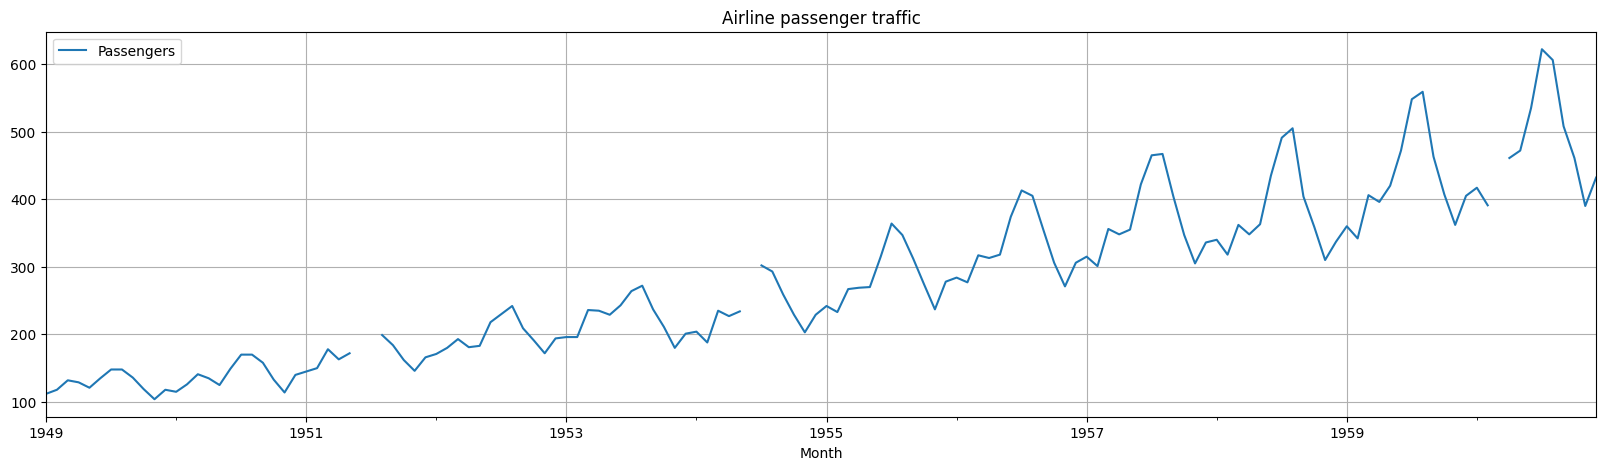

In [3]:
data.plot(figsize=(20, 5))
plt.grid()
plt.legend(loc='best')
plt.title('Airline passenger traffic')
plt.show(block=False)

Here we can see that there is missing data so we try to fill that data by using different technique like

1. Forward Fill (or Last Observation Carried Forward - LOCF)
2. Backward Fill
3. Linear Interpolation
4. Polynomial Interpolation

as the data shows a trend and seasonal patterns, inear interpolation will works well for the gaps.



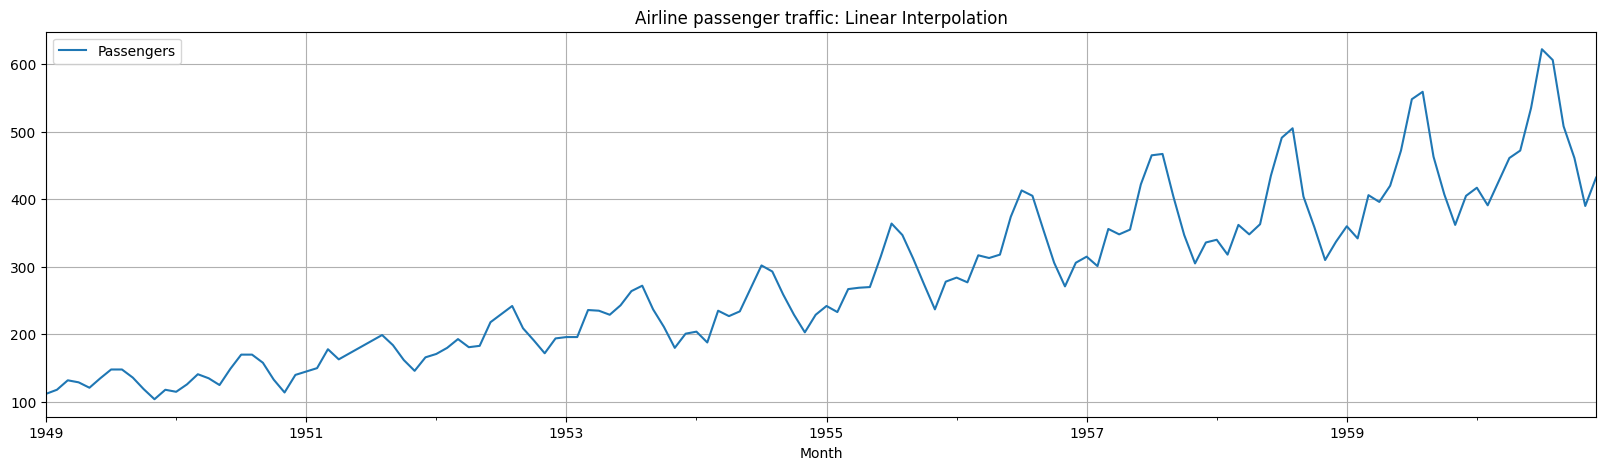

In [4]:
data['Passengers'] = data['Passengers'].interpolate(method='linear')
data.plot(figsize=(20, 5))
plt.title('Airline passenger traffic: Linear Interpolation')
plt.grid(True)
plt.show()


## Outlier detection

here we try to detect the outlier by using technique like:
1. Statistical Method: Z-Score
2. Interquartile Range (IQR)
3. Time series Decomposition

## 1. Statistical Method: Z-Score
The Z-score measures how far a data point is from the mean in terms of standard deviations. If the Z-score is greater than a threshold (e.g., 3 or -3), the data point is considered an outlier.

In [6]:
from scipy.stats import zscore

# Calculate Z-scores for the 'Passengers' column
data['zscore'] = zscore(data['Passengers'])

# Define a threshold (e.g., absolute Z-score > 3 for outliers)
outliers = data[data['zscore'].abs() > 3]

print(outliers)

Empty DataFrame
Columns: [Passengers, zscore]
Index: []


## 2. Box plot and Interquartile Range (IQR)
Description: A box plot can help identify potential outliers and the IQR method is based on the range between the first quartile (Q1) and the third quartile (Q3). Outliers are typically defined as values that lie outside the range.

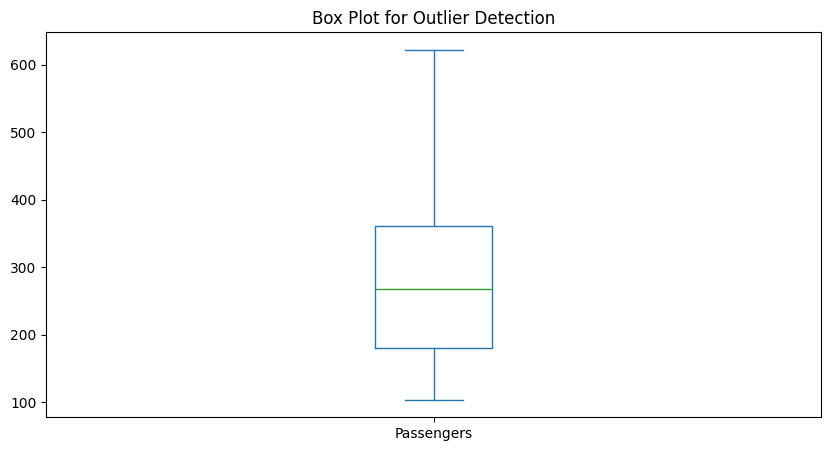

In [9]:
import matplotlib.pyplot as plt

# Box plot
data['Passengers'].plot(kind='box', figsize=(10, 5))
plt.title('Box Plot for Outlier Detection')
plt.show()


## 3. Time series decomposition
Time series decomposition is a technique that separates a time series into several components, typically:

- Trend: The long-term progression of the series.
- Seasonality: The repeating short-term cycle or pattern in the data.
- Residual (or Irregular): The random noise or leftover component after removing the trend and seasonality.

### Additive seasonal decomposition

In additive decomposition, the components are added together, so it assumes that the magnitude of seasonal fluctuations and residuals is constant over time. This is suitable when the seasonal variations are roughly constant.

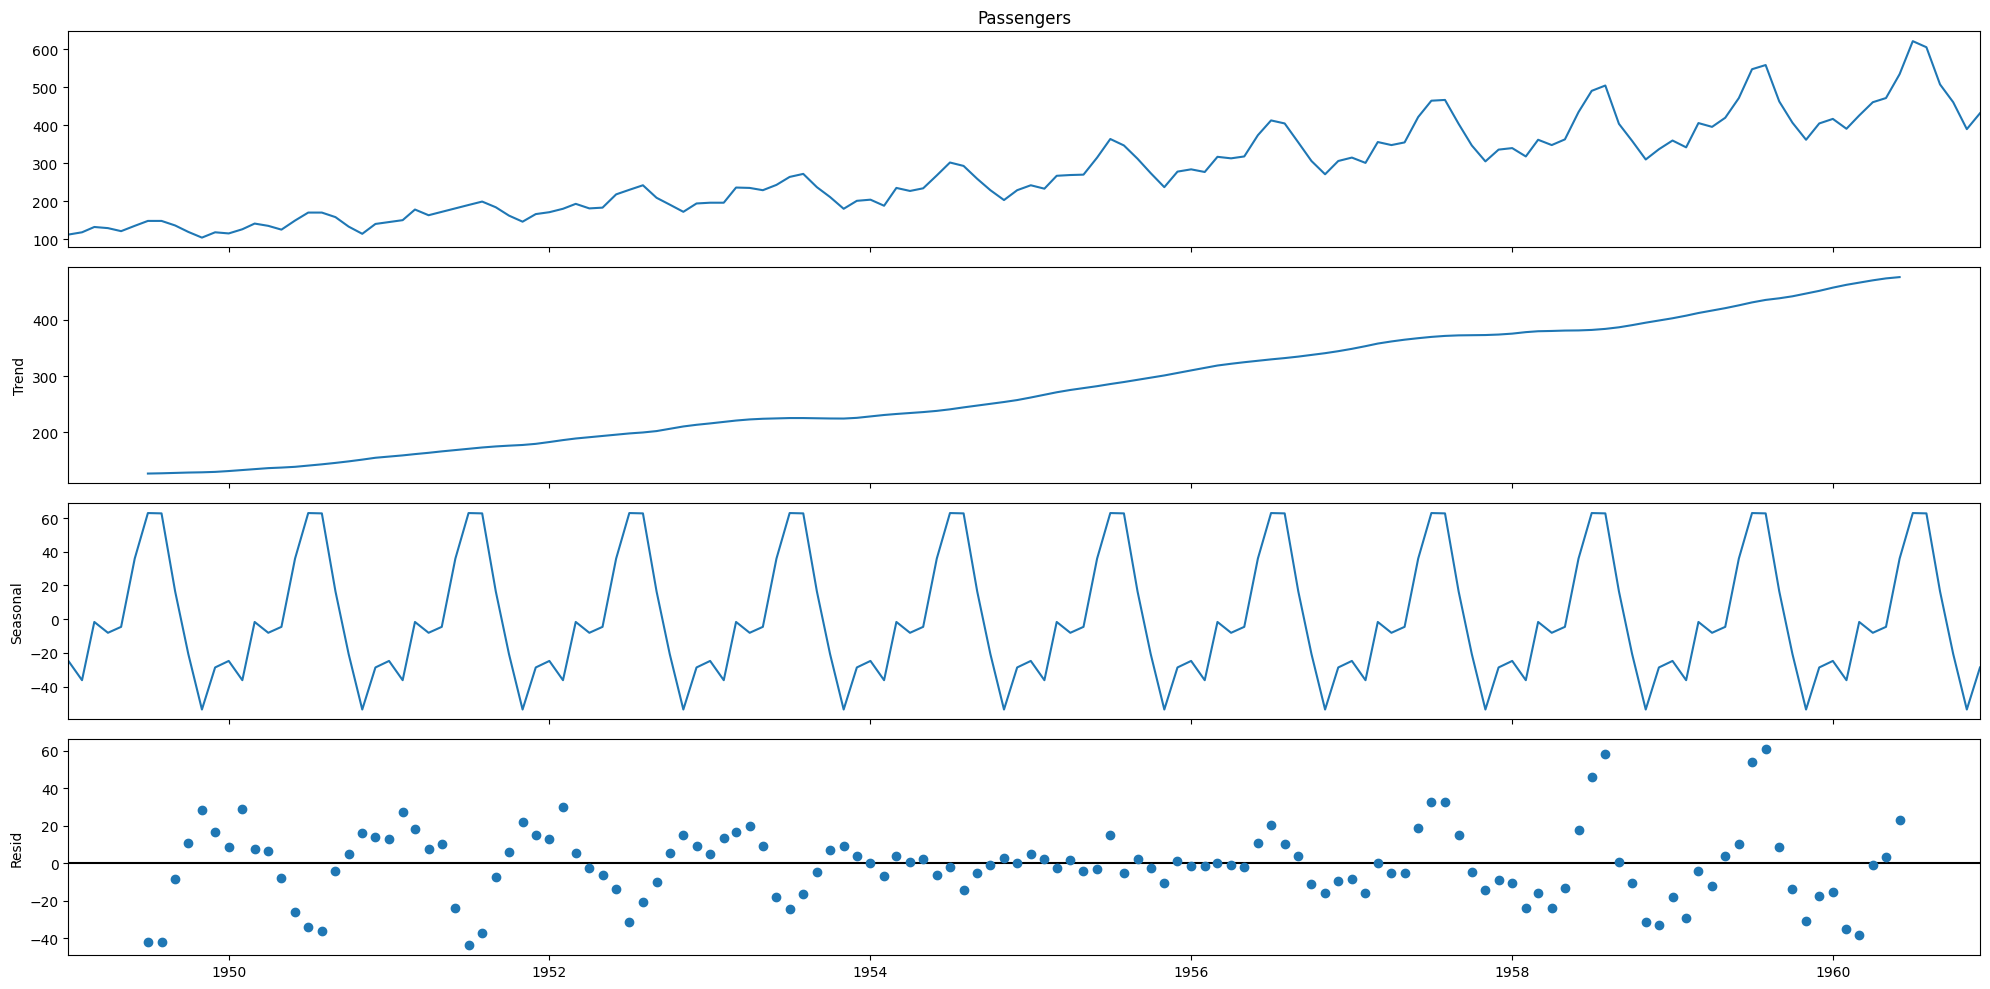

In [10]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 20, 10
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

### Multiplicative Seasonal Decomposition

Multiplicative seasonal decomposition is another method used to decompose a time series into three components: trend, seasonality, and residual. However, unlike the additive decomposition, the multiplicative decomposition assumes that the relationship between these components is multiplicative, rather than additive.

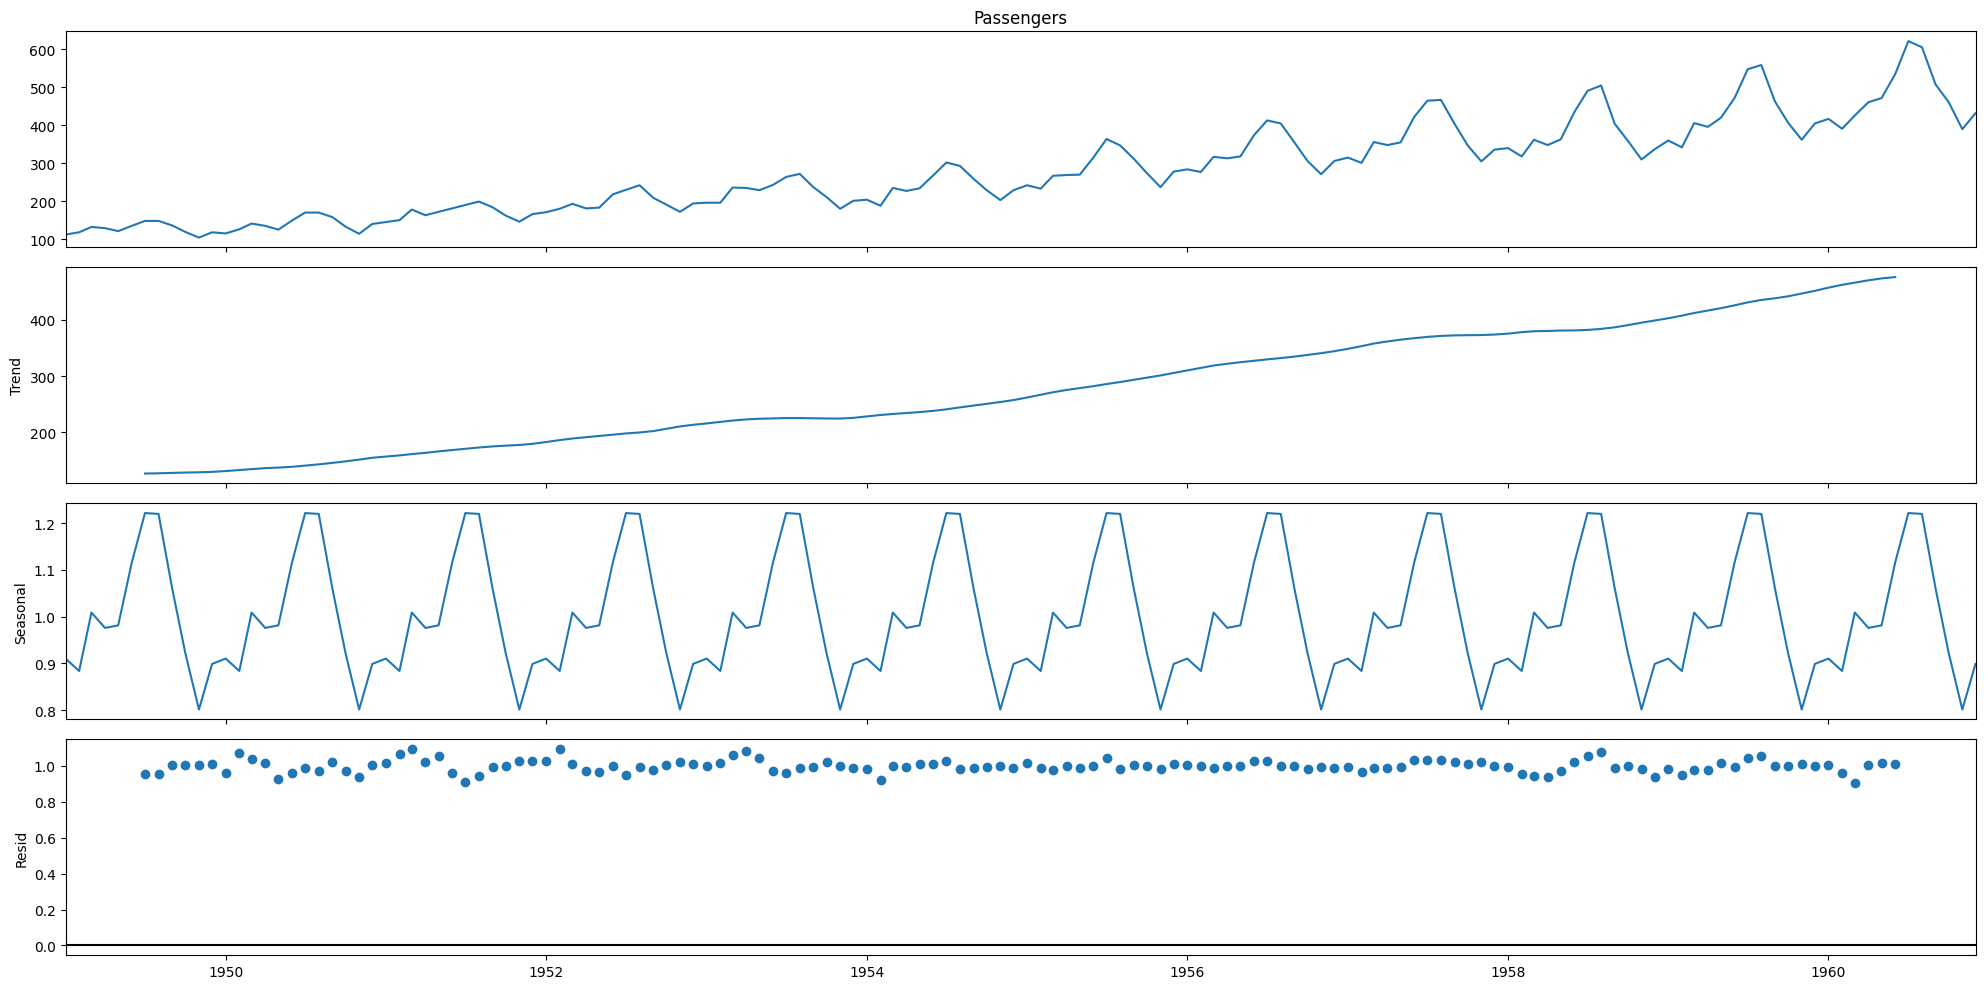

In [11]:
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

Here we can generalise that the plot indicates the number of passengers is influenced by both a long-term upward trend and a strong seasonal pattern. we can also see that the number of passengers tends to increase over time, but also fluctuates significantly within each year.

# Build and Evaluate SARIMAX Model

## Split time series data into training and test set

In [14]:
len(data)

144

In [15]:
train_len = 120
train = data[0:train_len] # first 120 months as training set
test = data[train_len:] # last 24 months as out-of-time test set

## Auto Regressive methods

## Stationarity vs non-stationary time series
Stationary Time Series has constant mean, variance, and autocovariance over time. It does not exhibit trends, seasonality, or structural changes.where as Non-Stationary Time Series has changing mean, variance, or autocovariance over time. It typically exhibits trends, seasonality, or volatility clustering.
For many forecasting models like SARIMAX, stationarity is a key assumption, and transforming non-stationary data to stationary is a necessary step before applying such models. 
1. Augmented Dickey-Fuller (ADF) test
2. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

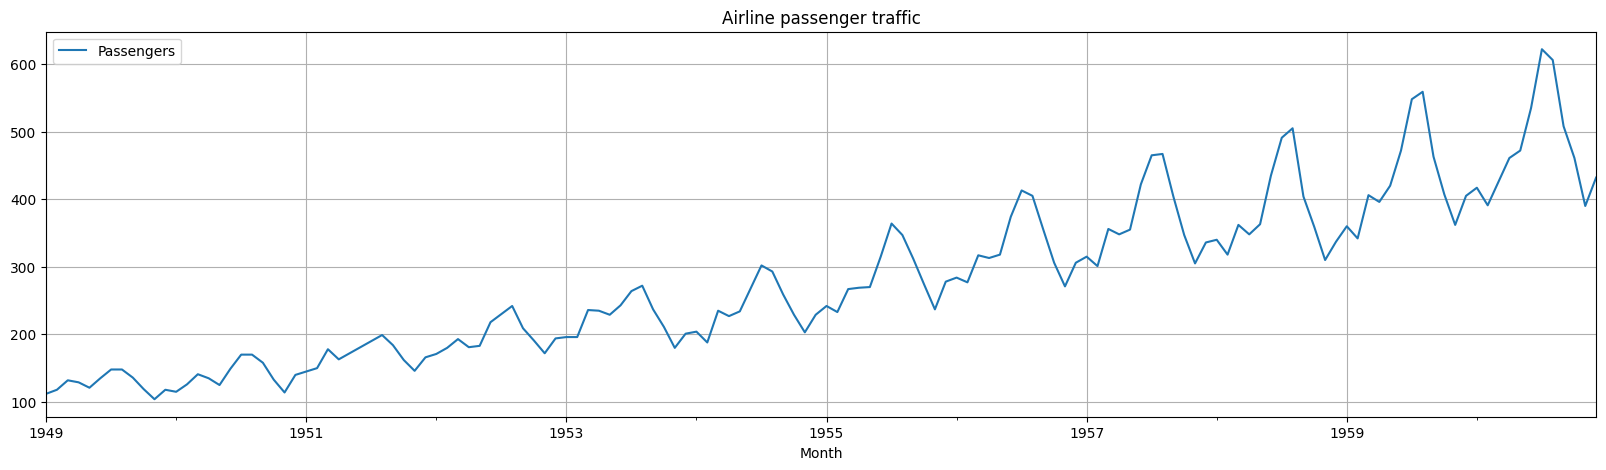

In [16]:
data['Passengers'].plot(figsize=(20, 5))
plt.grid()
plt.legend(loc='best')
plt.title('Airline passenger traffic')
plt.show(block=False)

### Augmented Dickey-Fuller (ADF) test
The ADF test is an extension of the Dickey-Fuller test, which allows for more complex time series models by including lagged values of the dependent variable to account for serial correlation.

Hypothesis of ADF Test:
- Null Hypothesis (H₀): The time series has a unit root, meaning it is non-stationary.
- Alternative Hypothesis (H₁): The time series does not have a unit root, meaning it is stationary.

Interpretation of Results:
- If the p-value is small (typically less than 0.05), you can reject the null hypothesis and conclude that the time series is stationary.
- If the p-value is large (greater than 0.05), you fail to reject the null hypothesis, meaning the time series is likely non-stationary.


In [18]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['Passengers'])

# Print the ADF test results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"  {key}: {value}")

ADF Statistic: 0.8946087940823831
p-value: 0.9930195647605924
Critical Values:
  1%: -3.4816817173418295
  5%: -2.8840418343195267
  10%: -2.578770059171598


- ADF Statistic (0.89460): The test statistic is too high, and it is not lower than the 5% critical value of -2.884.
- p-value (0.993): Since the p-value is greater than 0.05, we fail to reject the null hypothesis and conclude that the time series is non-stationary.

### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test
The Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test is another statistical test used to check the stationarity of a time series. It is often used in conjunction with the Augmented Dickey-Fuller (ADF) test to confirm the stationarity of a time series. While the ADF test has the null hypothesis that the series has a unit root (non-stationary), the KPSS test has the null hypothesis that the series is stationary.

Hypothesis of KPSS Test:
- Null Hypothesis (H₀): The series is stationary (either trend stationary or level stationary).
- Alternative Hypothesis (H₁): The series is non-stationary, i.e., it has a unit root.

Interpretation of Results
- If the p-value is small (e.g., < 0.05): This suggests that the time series is non-stationary (reject the null hypothesis of stationarity).
- If the p-value is large (e.g., > 0.05): This suggests that the time series is stationary (fail to reject the null hypothesis of stationarity).

In [19]:

from statsmodels.tsa.stattools import kpss
result = kpss(data['Passengers'], regression='c', nlags='auto')  # 'c' for level stationarity, 'ct' for trend stationarity

# Print the results
print(f'KPSS Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values: {result[2]}')

# Interpretation of the result
if result[1] < 0.05:
    print("The series is non-stationary.")
else:
    print("The series is stationary.")

KPSS Statistic: 1.651189746942162
p-value: 0.01
Critical Values: 8
The series is non-stationary.


C:\Users\Nitesh Rajbanshi\AppData\Local\Temp\ipykernel_13556\3591833185.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(data['Passengers'], regression='c', nlags='auto')  # 'c' for level stationarity, 'ct' for trend stationarity


now to make that a time series is stationary, we may need to address both the variance and trend in the data. Below, we'll explain two common techniques used to achieve this: 
1. Box-Cox transformation
2. differencing.

### 1. Box-Cox Transformation (Variance Stabilization)
The Box-Cox transformation is a family of power transformations that helps stabilize the variance of a time series. It is particularly useful when the data exhibits heteroscedasticity (changing variance over time), which can hinder the performance of time series models. By applying the Box-Cox transformation, we aim to make the variance constant over time, making the time series more suitable for modeling.

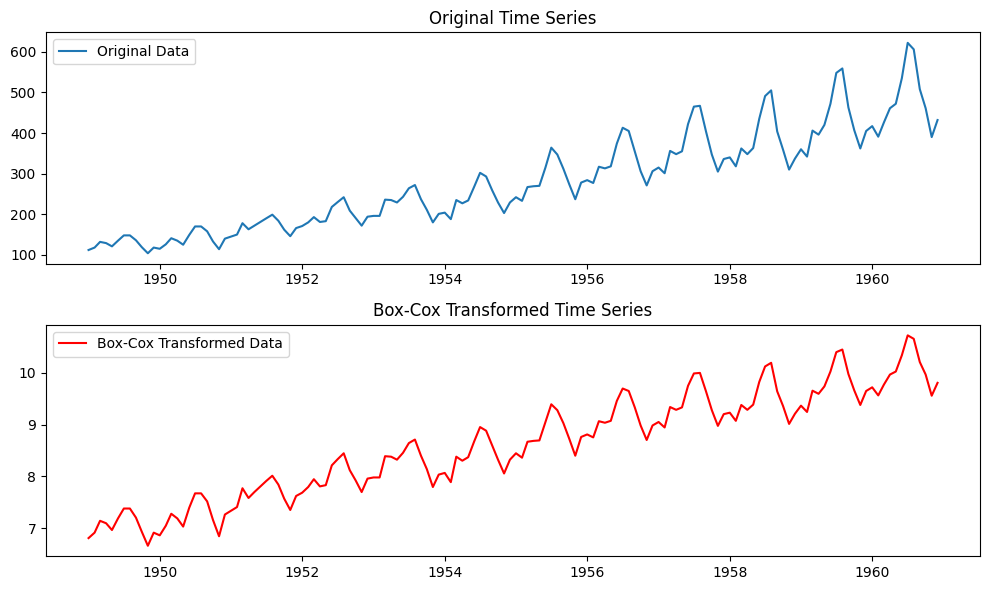

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import boxcox

# Apply Box-Cox transformation to stabilize variance
data_boxcox = pd.Series(boxcox(data['Passengers'], lmbda=0), index = data.index)

# Plot original and transformed data
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(data['Passengers'], label='Original Data')
plt.title('Original Time Series')
plt.legend()

plt.subplot(212)
plt.plot(data['Passengers_BoxCox'], label='Box-Cox Transformed Data', color='red')
plt.title('Box-Cox Transformed Time Series')
plt.legend()

plt.tight_layout()
plt.show()



### 2. Differencing to Remove Trend
Differencing is a technique used to remove trends and achieve stationarity. Differencing helps to remove the trend component of a time series, turning it into a stationary series (where statistical properties such as mean and variance remain constant over time).

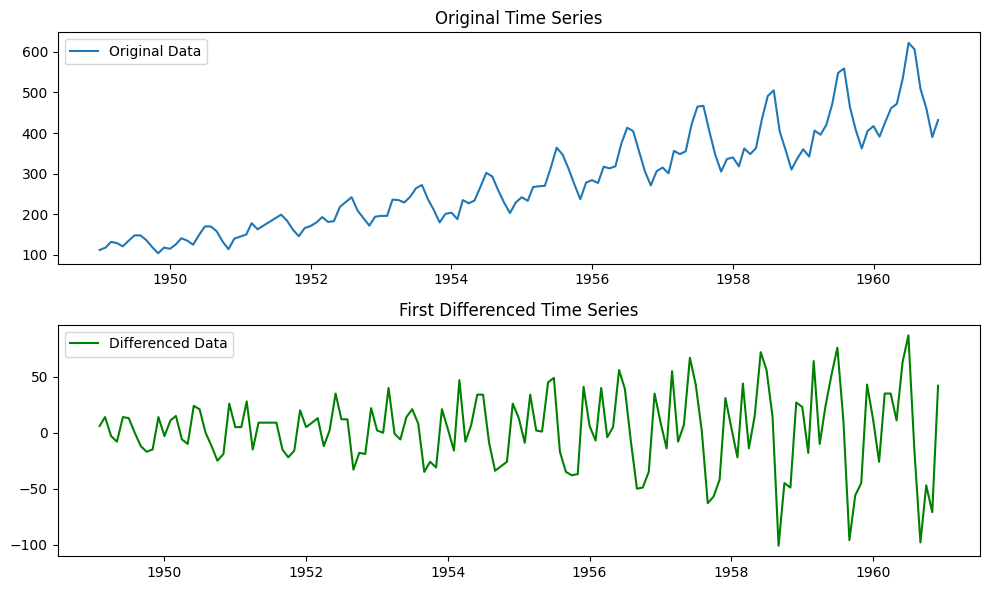

In [ ]:
# Apply first differencing to remove trend
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data.index)

# Plot original and differenced data
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(data['Passengers'], label='Original Data')
plt.title('Original Time Series')
plt.legend()

plt.subplot(212)
plt.plot(data['Passengers_diff'], label='Differenced Data', color='green')
plt.title('First Differenced Time Series')
plt.legend()

plt.tight_layout()
plt.show()


In [29]:
data_boxcox_diff.dropna(inplace=True)

In [30]:
data_boxcox_diff.tail()

Month
1960-08-01   -0.026060
1960-09-01   -0.176399
1960-10-01   -0.097083
1960-11-01   -0.167251
1960-12-01    0.102279
dtype: float64

In [33]:
#  Augmented Dickey-Fuller (ADF) test
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

# Interpretation of the result
if adf_test[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary.")

ADF Statistic: -3.290114
Critical Values @ 0.05: -2.88
p-value: 0.015326
The series is stationary.


In [34]:
# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

# Interpretation of the result
if result[1] < 0.05:
    print("The series is non-stationary.")
else:
    print("The series is stationary.")

KPSS Statistic: 0.038341
Critical Values @ 0.05: 0.46
p-value: 0.100000
The series is stationary.


C:\Users\Nitesh Rajbanshi\AppData\Local\Temp\ipykernel_13556\1273280356.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(data_boxcox_diff)


## Autocorrelation function (ACF)
The Autocorrelation Function (ACF) is a statistical tool used to measure the correlation of a time series with its own lagged (previous) values. It quantifies the degree to which a time series is correlated with its past values at different time lags.

In simple terms, the ACF tells you how a current value in the series is related to its previous values over time. If a time series has strong autocorrelation, the current value might depend heavily on past values.

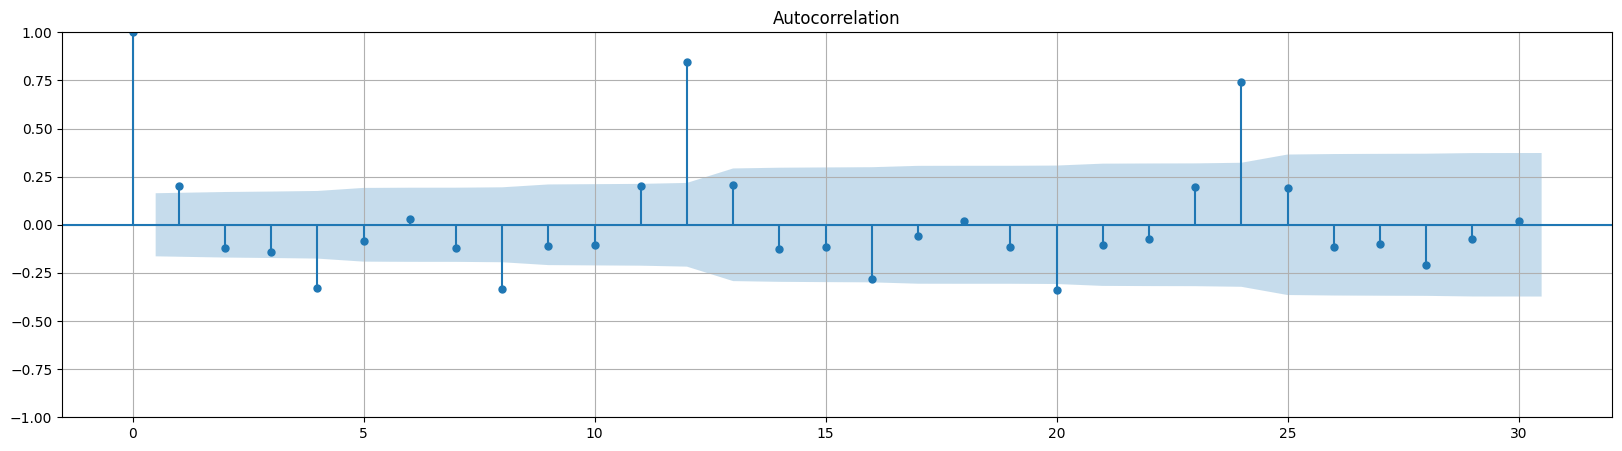

In [35]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(20,5))
plt.grid()
plot_acf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

here, from the plot we can see:

- Lag 0 always has an autocorrelation of 1, as the series is perfectly correlated with itself.
- Some lags appear to have significant correlations (falling outside the blue shaded region), which may indicate autocorrelation.
- The blue shaded region represents the confidence interval. Any points outside this region are considered statistically significant correlations.

## Partial autocorrelation function (PACF)

It measures the correlation between a time series and its lagged values after removing the effect of intervening lags. It is particularly useful for identifying the direct relationship between a time series and its past values, independent of the values at shorter lags.

In simpler terms, PACF shows the pure or partial correlation at each lag, accounting for the effects of the shorter lags.

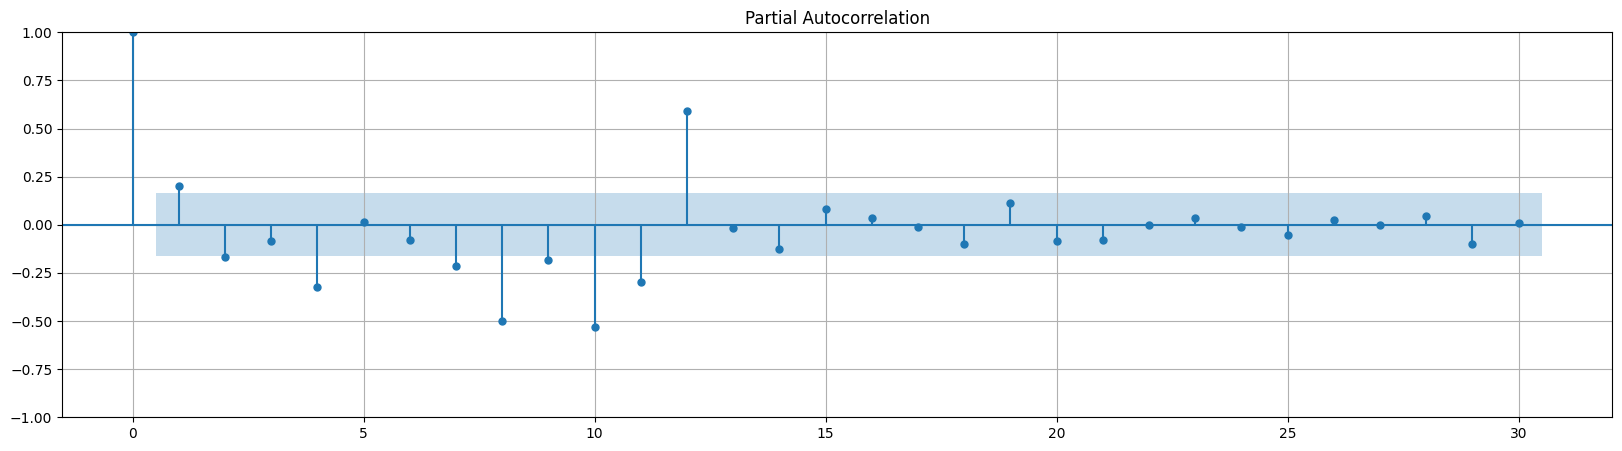

In [36]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(20,5))
plt.grid()
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

This plot suggests a time series where lag 1 is highly significant, as the value exceeds the confidence interval. There is another noticeable spike at lag 10, indicating potential autocorrelation at that point. 
Beyond these lags, the values mostly fall within the confidence intervals, implying weak or negligible partial autocorrelation at higher lags.

Split the data now  and make useful

In [37]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

In [38]:
train_data_boxcox_diff[:5]

Month
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
dtype: float64

In [39]:
promo = pd.read_csv('promotion.csv', header = None)
promo.columns = ['Month','Event']
promo['Month'] = pd.to_datetime(promo['Month'], format='%Y-%m')
promo = promo.set_index('Month')
promo.head(12)

,Event
Month,
1949-01-01,0
1949-02-01,0
1949-03-01,0
1949-04-01,0
1949-05-01,0
1949-06-01,0
1949-07-01,0
1949-08-01,0
1949-09-01,0


In [40]:
promo_train = promo[0:train_len] # first 120 months as training set
promo_test = promo[train_len:] # last 24 months as out-of-time test set

## Seasonal auto regressive integrated moving average with external variables (SARIMAX)

In [42]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12),exog=promo_train) 
model_fit = model.fit()
print(model_fit.params)
model_fit.summary()

d:\6th_semester\Advance_machine_learning\YAGAY CHAPTER 2\Time-Series-Forecasting-SARIMAX\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\6th_semester\Advance_machine_learning\YAGAY CHAPTER 2\Time-Series-Forecasting-SARIMAX\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Event       0.034329
ar.L1       0.479280
ma.L1      -0.741921
ar.S.L12   -0.063692
ma.S.L12   -0.558328
sigma2      0.001334
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 199.508
Date:                            Fri, 03 Jan 2025   AIC                           -387.017
Time:                                    23:38:54   BIC                           -370.980
Sample:                                01-01-1949   HQIC                          -380.516
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Event          0.0343      0.024      1.417      0.157      -0.013       0.082
ar.L1          0.4793      0.214      2.244      0.025       0.061       0.898
ma.L1         -0.7419      0.174     -4.263      0.000      -1.083      -0.401
ar.S.L12      -0.0637      0.234     -0.273      0.785      -0.522       0.394
ma.S.L12      -0.5583      0.255     -2.187      0.029      -1.059      -0.058
sigma2         0.0013      0.000      7.401      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.72
Prob(Q):                              0.98   Prob(JB):                         0.09
Heteroskedasticity (H):               0.41   Skew:                            -0.03
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Recover original time series forecast

In [43]:
y_hat_sarimax = data_boxcox_diff.copy()
y_hat_sarimax['sarimax_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max(),exog=promo_test)
y_hat_sarimax['sarimax_forecast'] = np.exp(y_hat_sarimax['sarimax_forecast_boxcox'])

### Plot train, test and forecast

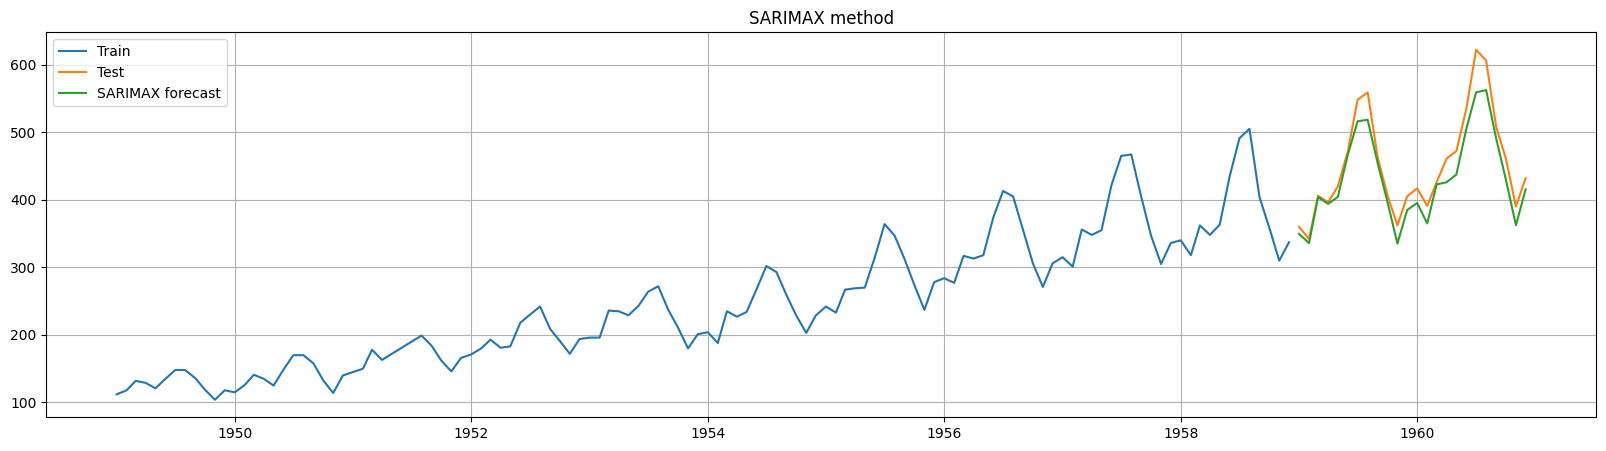

In [44]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sarimax['sarimax_forecast'][test.index.min():], label='SARIMAX forecast')
plt.legend(loc='best')
plt.title('SARIMAX method')
plt.show()

The training data is represented in blue, the test data in orange, and the SARIMAX forecast in green. The SARIMAX forecast closely aligns with the test data, capturing the seasonal patterns and trends effectively, indicating a well-fitted model. However, minor deviations suggest there is still room for improvement in prediction accuracy.